In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path
from pathlib import Path
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.optimizers import RMSprop, Adam, Optimizer, Optimizer, Adagrad
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, MaxPooling2D, BatchNormalization, \
    Permute, TimeDistributed, Bidirectional, GRU, SimpleRNN, LSTM, GlobalAveragePooling2D, SeparableConv2D
import tensorflow as tf
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from warnings import filterwarnings
filterwarnings("ignore", category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning)
filterwarnings("ignore", category=UserWarning)

In [2]:
# папки
train_path = list(Path("./Parkinson's Drawings/spiral/training").glob(r"*/*.png"))
test_path = list(Path("./Parkinson's Drawings/spiral/testing").glob(r"*/*.png"))
# метки
train_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], train_path))
test_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], test_path))
# датафрейм
train_data = pd.concat([pd.Series(train_path, name="PNG").astype(str), pd.Series(train_labels, name="CATEGORY")], axis=1)
test_data = pd.concat([pd.Series(test_path, name="PNG").astype(str), pd.Series(test_labels, name="CATEGORY")], axis=1)
# перемешивание
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

### Изображения тренировочного набора

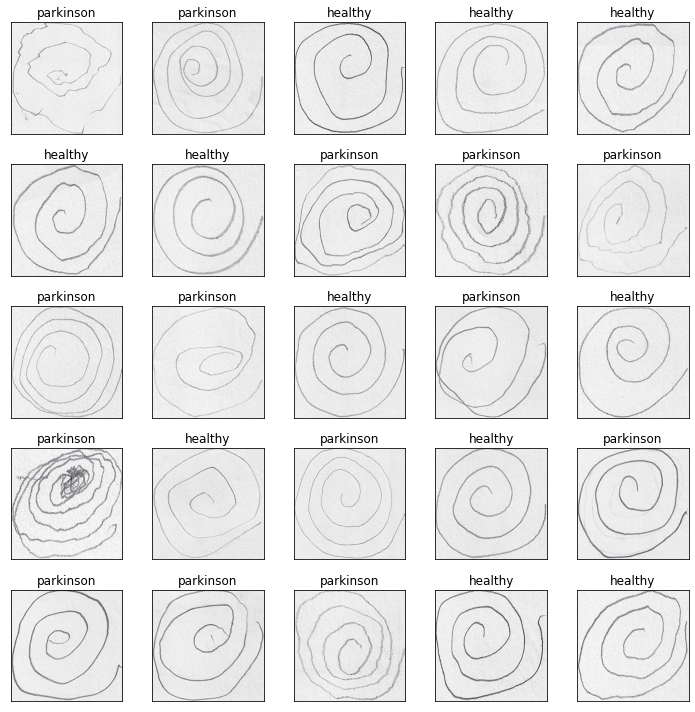

In [3]:
# общая картинка
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_data["PNG"][i]))
    ax.set_title(train_data["CATEGORY"][i])
plt.tight_layout()
plt.show()

### Изображения тестового набора

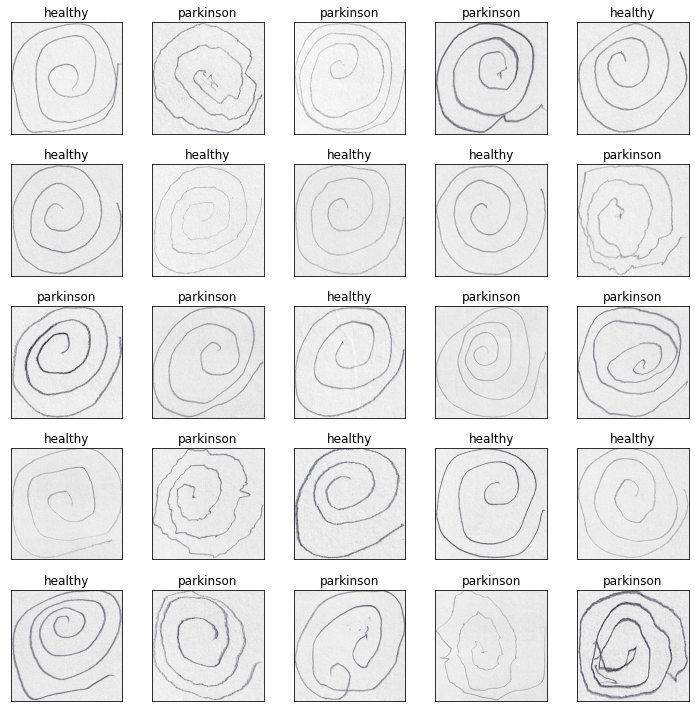

In [4]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10,10), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_data["PNG"][i]))
    ax.set_title(test_data["CATEGORY"][i])
plt.tight_layout()
plt.show()

### Тренировка и тестирование на датасете

In [5]:
# трансформация
path = []
for i in range(0, 72):
    path.append(np.array(cv2.imread(train_data["PNG"][i])).astype("float32").mean()/255)

train = pd.concat([pd.Series(path, name="PNG"), pd.Series(LabelEncoder().fit_transform(train_data["CATEGORY"]), name="CATEGORY")], axis=1)

path = []
for i in range(0, 30):
    path.append(np.array(cv2.imread(test_data["PNG"][i])).astype("float32").mean()/255)

test = pd.concat([pd.Series(path, name="PNG"), pd.Series(LabelEncoder().fit_transform(test_data["CATEGORY"]), name="CATEGORY")], axis=1)
# тренировка и тестирование
xTrain, xTest, yTrain, yTest = train_test_split(pd.concat([train,test])[["PNG"]], pd.concat([train,test])["CATEGORY"], test_size=0.3, random_state=42)
#xTrain, yTrain, xTest, yTest = train[["PNG"]], train["CATEGORY"], test[["PNG"]], test["CATEGORY"]
models = [LogisticRegression(solver="liblinear").fit(xTrain, yTrain),
           GaussianNB().fit(xTrain, yTrain),
           KNeighborsClassifier().fit(xTrain, yTrain),
           DecisionTreeClassifier().fit(xTrain, yTrain),
           RandomForestClassifier(verbose=False).fit(xTrain, yTrain),
           GradientBoostingClassifier(verbose=False).fit(xTrain, yTrain),
           XGBClassifier().fit(xTrain, yTrain),
           LGBMClassifier().fit(xTrain, yTrain),
           CatBoostClassifier(verbose=False).fit(xTrain, yTrain)]
table_acc = pd.DataFrame(columns=['model','accuracy'])
i = 0
for model in models:
    predict = model.predict(xTest)
    table_acc.loc[i] = [model.__class__.__name__, accuracy_score(yTest, predict)]
    i += 1
table_acc

[20:20:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,model,accuracy
0,LogisticRegression,0.419355
1,GaussianNB,0.451613
2,KNeighborsClassifier,0.483871
3,DecisionTreeClassifier,0.580645
4,RandomForestClassifier,0.580645
5,GradientBoostingClassifier,0.580645
6,XGBClassifier,0.612903
7,LGBMClassifier,0.548387
8,CatBoostClassifier,0.548387


### Генерация новых изображений

In [6]:
# генерация изображения
generator = ImageDataGenerator(rescale=1./255, #показатель масштабирования данных
                                    #zoom_range=0.7, #Диапазон случайного выбора масштабирования изображения.
                                    shear_range=0.7, #диапазон сдвига пикселей изображения
                                    rotation_range=50, #поворот изображения в градусах
                                    horizontal_flip=True,
                                    #brightness_range=[0.4, 0.6], #диапазон выбора сдвига по яркости
                                    vertical_flip=True)


train_data_generate = generator.flow_from_dataframe(dataframe=train_data,
                                                   x_col="PNG",
                                                   y_col="CATEGORY",
                                                   batch_size = 72,
                                                   shuffle=False,
                                                   class_mode="categorical",
                                                   subset="training")

test_data_generate = generator.flow_from_dataframe(dataframe=test_data,
                                                   x_col="PNG",
                                                   y_col="CATEGORY",
                                                   batch_size = 30,
                                                   shuffle=False,
                                                   class_mode="categorical")
# трансформация
path = []
for i in range(0, 72):
    path.append(train_data_generate[0][0][i].mean())

train_generate = pd.concat([pd.Series(path, name="PNG"), pd.Series(train_data_generate.classes, name="CATEGORY")], axis=1)

path = []
for i in range(0, 30):
    path.append(test_data_generate[0][0][i].mean())

test_generate = pd.concat([pd.Series(path, name="PNG"), pd.Series(test_data_generate.classes, name="CATEGORY")], axis=1)

Found 72 validated image filenames belonging to 2 classes.
Found 30 validated image filenames belonging to 2 classes.


### Сгенерированные изображения тренировочного набора

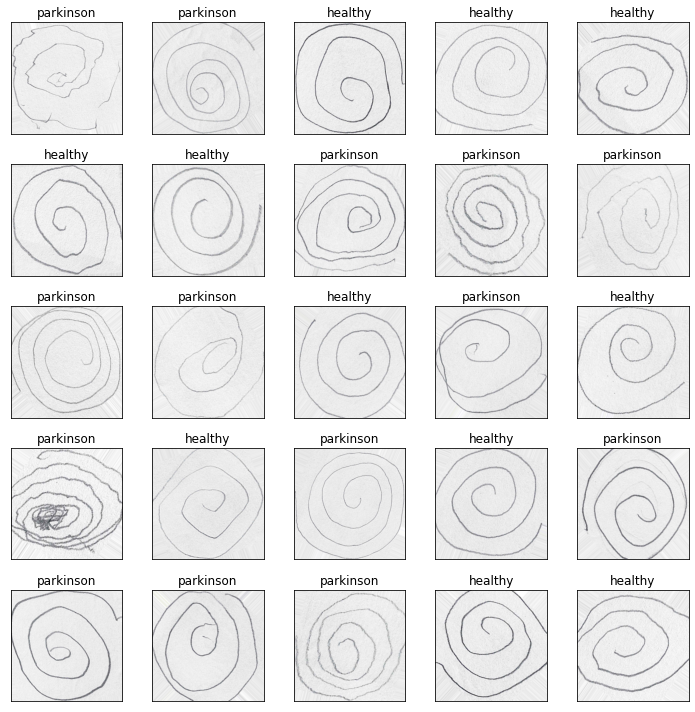

In [7]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(train_data_generate[0][0][i])
    ax.set_title('parkinson' if train_data_generate.classes[i] == 1 else 'healthy')
plt.tight_layout()
plt.show()

### Сгенерированные изображения тестового набора

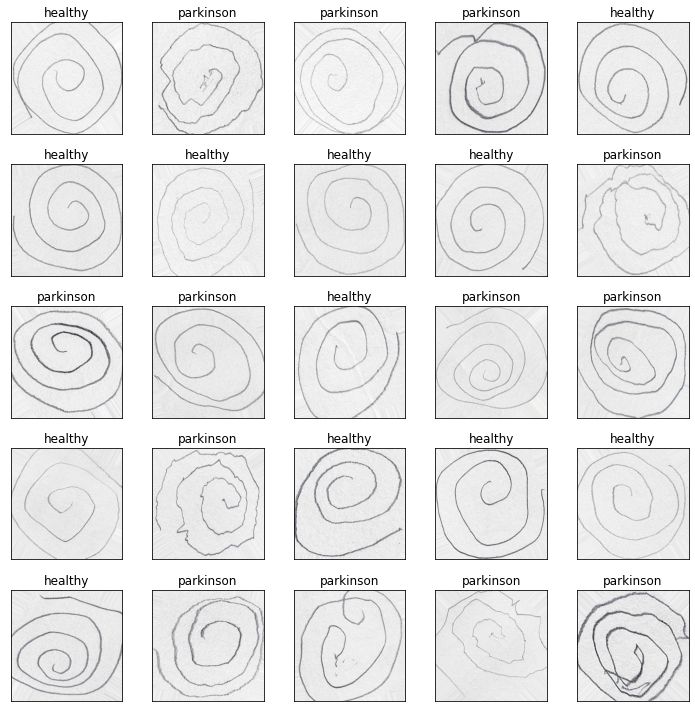

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(test_data_generate[0][0][i])
    ax.set_title('parkinson' if test_data_generate.classes[i] == 1 else 'healthy')
plt.tight_layout()
plt.show()

### Тренировка и тестирование на сгенерированных изображениях

In [9]:
# тренировка и тестирование
xTrain, xTest, yTrain, yTest = train_test_split(pd.concat([train_generate,test_generate])[["PNG"]], pd.concat([train_generate,test_generate])["CATEGORY"], test_size=0.3, random_state=42)
#xTrain, yTrain, xTest, yTest = train[["PNG"]], train["CATEGORY"], test[["PNG"]], test["CATEGORY"]
models = [LogisticRegression(solver="liblinear").fit(xTrain, yTrain),
           GaussianNB().fit(xTrain, yTrain),
           KNeighborsClassifier().fit(xTrain, yTrain),
           DecisionTreeClassifier().fit(xTrain, yTrain),
           RandomForestClassifier(verbose=False).fit(xTrain, yTrain),
           GradientBoostingClassifier(verbose=False).fit(xTrain, yTrain),
           XGBClassifier().fit(xTrain, yTrain),
           LGBMClassifier().fit(xTrain, yTrain),
           CatBoostClassifier(verbose=False).fit(xTrain, yTrain)]
table_acc = pd.DataFrame(columns=['model','accuracy'])
i = 0
for model in models:
    predict = model.predict(xTest)
    table_acc.loc[i] = [model.__class__.__name__, accuracy_score(yTest, predict)]
    i += 1
table_acc

[20:22:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,model,accuracy
0,LogisticRegression,0.419355
1,GaussianNB,0.483871
2,KNeighborsClassifier,0.516129
3,DecisionTreeClassifier,0.419355
4,RandomForestClassifier,0.419355
5,GradientBoostingClassifier,0.419355
6,XGBClassifier,0.451613
7,LGBMClassifier,0.516129
8,CatBoostClassifier,0.483871


### Тренировка и тестирование на всех данных

In [10]:
# тренировка и тестирование
xTrain, xTest, yTrain, yTest = train_test_split(pd.concat([train,test,train_generate,test_generate])[["PNG"]], pd.concat([train,test,train_generate,test_generate])["CATEGORY"], test_size=0.3, random_state=42)
#xTrain, yTrain, xTest, yTest = train[["PNG"]], train["CATEGORY"], test[["PNG"]], test["CATEGORY"]
models = [LogisticRegression(solver="liblinear").fit(xTrain, yTrain),
           GaussianNB().fit(xTrain, yTrain),
           KNeighborsClassifier().fit(xTrain, yTrain),
           DecisionTreeClassifier().fit(xTrain, yTrain),
           RandomForestClassifier(verbose=False).fit(xTrain, yTrain),
           GradientBoostingClassifier(verbose=False).fit(xTrain, yTrain),
           XGBClassifier().fit(xTrain, yTrain),
           LGBMClassifier().fit(xTrain, yTrain),
           CatBoostClassifier(verbose=False).fit(xTrain, yTrain)]
table_acc = pd.DataFrame(columns=['model','accuracy'])
i = 0
for model in models:
    predict = model.predict(xTest)
    table_acc.loc[i] = [model.__class__.__name__, accuracy_score(yTest, predict)]
    i += 1
table_acc

[20:22:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,model,accuracy
0,LogisticRegression,0.483871
1,GaussianNB,0.532258
2,KNeighborsClassifier,0.564516
3,DecisionTreeClassifier,0.500000
4,RandomForestClassifier,0.500000
5,GradientBoostingClassifier,0.532258
6,XGBClassifier,0.483871
7,LGBMClassifier,0.596774
8,CatBoostClassifier,0.629032
